# Glimpse of our Double Descent Experiments

This notebook resume our best illustrations of the double descent phenomenon. Each part is independent from each other. 
- The first part shows the double descent for classical ML algorithms, trained on real dataset, the taxi trip pricing dataset.
- The second part  focuses on deep learning and neural network. The models are trained on the CIFAR dataset or the MNIST dataset.
- The third part tries to show clearly the phenomemon with synthetic data. 

## Librairies importation 

In [1]:
# core libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
import pandas as pd
import seaborn as sns

# tensorflow
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers, optimizers, losses
#from keras.callbacks import Callback

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor

# scipy
from scipy.interpolate import make_interp_spline

# XGBoost
import xgboost as xgb

## I - Experiences on Taxi trip pricing dataset

In this part, all models are trained on the Taxi trip pricing dataset from kaggle.

### Preprocessing

Here we import the taxi trip pricing dataset and we preprocess it (encoding, drop na).

In [2]:
# Importing the dataset
taxi_df = pd.read_csv('taxi_trip_pricing.csv')

# Dropping rows with missing values for the target variable
taxi_df = taxi_df.dropna(subset=['Trip_Price'])

y = taxi_df['Trip_Price']
taxi_df = taxi_df.drop(columns=['Trip_Price'])

# Preprocessing
for col in taxi_df.columns:
    if taxi_df[col].dtype == 'object':
        # Remplacer les valeurs manquantes par la classe majoritaire
        taxi_df.fillna({col:taxi_df[col].mode()[0]}, inplace=True)
    else:
        # Remplacer les valeurs manquantes par la médiane
        taxi_df.fillna({col:taxi_df[col].median()}, inplace=True)

# Encoding
one_hot_cols = ["Time_of_Day", "Day_of_Week", "Weather","Traffic_Conditions" ]  # Colonnes catégorielles pour One-Hot
one_hot_encoded = pd.get_dummies(taxi_df[one_hot_cols], prefix=one_hot_cols, dummy_na=False)

taxi_df = pd.concat([taxi_df, one_hot_encoded], axis=1)
X_df = taxi_df.drop(columns=one_hot_cols)

#Division train/test
X_train, X_test, y_train, y_test = train_test_split(X_df.values, y, test_size=0.3, random_state=123)

### ADA BOOST

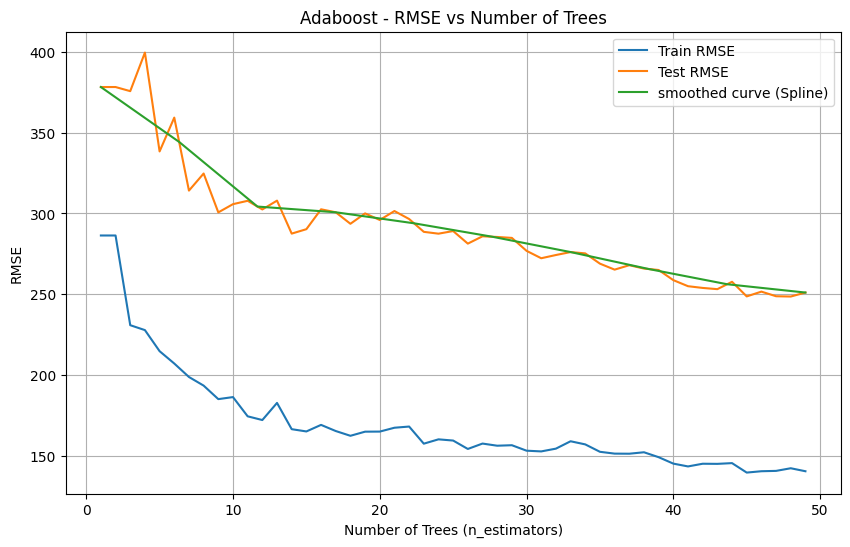

In [3]:
# Liste des nombres d'arbres à tester
n_trees = list(range(1, 50))  # De 10 à 500 arbres par pas de 10
train_rmse_list = []
test_rmse_list = []

# Boucle pour entraîner des Random Forest avec différents nombres d'arbres
for n in n_trees:
    ada_model = AdaBoostRegressor(
        n_estimators=n,
        random_state=123,
    )
    
    ada_model.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train = ada_model.predict(X_train)
    y_pred_test = ada_model.predict(X_test)
    
    # Calcul du RMSE
    train_rmse = mean_squared_error(y_train, y_pred_train)
    test_rmse = mean_squared_error(y_test, y_pred_test)
    
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(n_trees, train_rmse_list, label='Train RMSE')
plt.plot(n_trees, test_rmse_list, label='Test RMSE')
# Interpolation spline

# Interpolation spline
x_smooth = np.linspace(min(n_trees), max(n_trees), 10)  # Génère plus de points
spline = make_interp_spline(n_trees, test_rmse_list, k=1)  # k=3 pour une spline cubique
y_smooth = spline(x_smooth)
# Tracé des courbes
plt.plot(x_smooth, y_smooth, '-', label='smoothed curve (Spline)')

plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.title('Adaboost - RMSE vs Number of Trees')
plt.legend()
plt.grid(True)
plt.show()


### Random Fourier Feature RFF 

Here, we use a random fourier feature before a linear regression, we clearly see the double descent with this model. 

An RFF model introduces a map z: $\mathbb{R}^d \to \mathbb{R}^N$ such that each input
$x \in \mathbb{R}^d$ is transformed via randomized cosine features. In the case of
approximating a Gaussian kernel, one typically sets:
$$
  z(x) \;=\;
  \sqrt{\tfrac{2}{N}}
  \begin{bmatrix}
    \cos(\omega_1^\top x + b_1)\\
    \vdots\\
    \cos(\omega_N^\top x + b_N)
  \end{bmatrix},
$$
where $\omega_i \sim \mathcal{N}(0, \sigma^2 I_d)$ and $b_i$ is sampled uniformly in
$[0,2\pi]$. A model in the RFF family is then
\[
  h_{\beta}(x) \;=\; \beta^\top z(x),
\]
where $\beta \in \mathbb{R}^N$ contains the \textbf{learnable} parameters. Observe that
$h_{\beta}(x)$ is \textbf{linear in} $\beta$ yet \textbf{non-linear in} $x$, which
is crucial: it links linear methods and kernel methods.

In [4]:
class RandomFourierFeatures:
    def __init__(self, input_dim, num_features, gamma=1.0):
        """
        Class to compute Random Fourier Features (RFF).

        Parameters:
        - input_dim : int, dimension of the input space.
        - num_features : int, number of features in the transformed space.
        - gamma : float, parameter of the RBF kernel (1 / (2 * sigma^2)).
        """
        self.input_dim = input_dim
        self.num_features = num_features
        self.gamma = gamma
        
        # Initialization of random vectors and biases
        self.W = np.sqrt(2 * gamma) * np.random.randn(input_dim, num_features)
        self.b = 2 * np.pi * np.random.rand(num_features)

    def transform(self, X):
        """
        Transforms input data X into the Random Fourier Features space.

        Parameters:
        - X : numpy.ndarray, input data of shape (n_samples, input_dim).

        Returns:
        - numpy.ndarray of shape (n_samples, num_features).
        """
        
        # Compute linear projection and add bias
        Z = X @ self.W + self.b
        
        # Apply cosine function and return the projection
        Z = np.asarray(Z, dtype=np.float64)
        return np.sqrt(2 / self.num_features) * np.cos(Z)


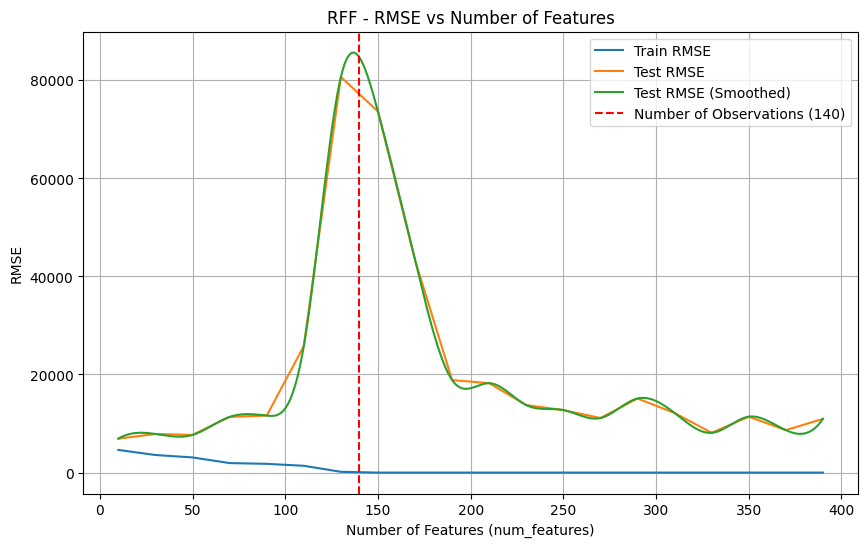

In [5]:
# We reduce to 200 samples
X_train, X_test, y_train, y_test = train_test_split(X_df.iloc[:200,:].values, y[:200], test_size=0.3, random_state=123)

# Parameters
input_dim = 18      # Dimension of the input space
gamma = 0.5        # Parameter of the RBF kernel

# List of number of features to test
n_features_list = list(range(10, 400, 20))
train_rmse_list = []
test_rmse_list = []

# Loop to train and evaluate RFF with different numbers of features
for num_features in n_features_list:
    rff = RandomFourierFeatures(input_dim, num_features, gamma)
    
    # Transform data
    X_train_transformed = rff.transform(X_train)
    X_test_transformed = rff.transform(X_test)

    # Fit a simple linear model in the transformed space
    weights = np.linalg.pinv(X_train_transformed) @ y_train

    # Predictions
    y_pred_train = X_train_transformed @ weights
    y_pred_test = X_test_transformed @ weights

    # Calculate RMSE
    train_rmse = mean_squared_error(y_train, y_pred_train)
    test_rmse = mean_squared_error(y_test, y_pred_test)

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

# Visualization of results
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, train_rmse_list, label='Train RMSE')
plt.plot(n_features_list, test_rmse_list, label='Test RMSE')

# Spline interpolation for smoother curves
x_smooth = np.linspace(min(n_features_list), max(n_features_list), 300)
spline_test = make_interp_spline(n_features_list, test_rmse_list, k=3)

y_smooth_test = spline_test(x_smooth)

plt.plot(x_smooth, y_smooth_test, '-', label='Test RMSE (Smoothed)')

plt.xlabel('Number of Features (num_features)')
plt.ylabel('RMSE')
plt.title('RFF - RMSE vs Number of Features')
plt.axvline(x=X_train.shape[0], color='red', linestyle='--', label=f'Number of Observations ({X_train.shape[0]})')
plt.legend()
plt.grid(True)
plt.show()

## II - Experiences on image classification (CIFAR, MNIST...)

This part focus on Deep learning and image classification. We began with a CNN on CIFAR and then we used Dense neural network on MNIST.

### CNN


Training with model complexity k=2...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         3,078 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │            70 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,556 (13.89 KB)

 Trainable params: 3,556 (13.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1295 - loss: 2.2639 - val_accuracy: 0.2714 - val_loss: 1.9552
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2896 - loss: 1.8796 - val_accuracy: 0.3309 - val_loss: 1.7842
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3521 - loss: 1.7559 - val_accuracy: 0.3486 - val_loss: 1.7503
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3705 - loss: 1.6783 - val_accuracy: 0.3619 - val_loss: 1.7412
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3967 - loss: 1.6127 - val_accuracy: 0.3881 - val_loss: 1.6516
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4103 - loss: 1.5882 - val_accuracy: 0.3933 - val_loss: 1.6345
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4022 - loss: 1.5863 - val_accuracy: 0.3916 - val_loss: 1.6290
Epoch 8/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4194 - loss: 1.5569 - val_accu

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         3,591 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,079 (15.93 KB)

 Trainable params: 4,079 (15.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0983 - loss: 2.3047 - val_accuracy: 0.1437 - val_loss: 2.2647
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1956 - loss: 2.1886 - val_accuracy: 0.2814 - val_loss: 1.9780
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2866 - loss: 1.9415 - val_accuracy: 0.2906 - val_loss: 1.8823
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3584 - loss: 1.7699 - val_accuracy: 0.3509 - val_loss: 1.7615
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3747 - loss: 1.7000 - val_accuracy: 0.3467 - val_loss: 1.7250
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3928 - loss: 1.6433 - val_accuracy: 0.3642 - val_loss: 1.7050
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4039 - loss: 1.6131 - val_accuracy: 0.3776 - val_loss: 1.6700
Early stopping triggered.

Training with model complexity k=4...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         4,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,602 (17.98 KB)

 Trainable params: 4,602 (17.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1506 - loss: 2.2479 - val_accuracy: 0.2290 - val_loss: 2.0824
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2382 - loss: 2.0496 - val_accuracy: 0.2672 - val_loss: 1.9943
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2971 - loss: 1.9374 - val_accuracy: 0.3090 - val_loss: 1.8854
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3297 - loss: 1.8403 - val_accuracy: 0.3047 - val_loss: 1.8627
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3273 - loss: 1.7921 - val_accuracy: 0.3430 - val_loss: 1.7708
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3632 - loss: 1.7060 - val_accuracy: 0.3517 - val_loss: 1.7619
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3817 - loss: 1.6573 - val_accuracy: 0.3763 - val_loss: 1.6888
Early stopping triggered.

Training with model complexity k=5...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 9)              │         4,617 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,125 (20.02 KB)

 Trainable params: 5,125 (20.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1169 - loss: 2.2936 - val_accuracy: 0.1659 - val_loss: 2.2181
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1883 - loss: 2.1751 - val_accuracy: 0.2478 - val_loss: 2.0723
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2581 - loss: 2.0277 - val_accuracy: 0.2874 - val_loss: 1.9583
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3054 - loss: 1.8958 - val_accuracy: 0.3005 - val_loss: 1.8448
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3198 - loss: 1.8369 - val_accuracy: 0.3175 - val_loss: 1.8125
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3426 - loss: 1.7356 - val_accuracy: 0.3225 - val_loss: 1.7752
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3539 - loss: 1.7152 - val_accuracy: 0.3331 - val_loss: 1.7680
Early stopping triggered.

Training with model complexity k=6...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,648 (22.06 KB)

 Trainable params: 5,648 (22.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1290 - loss: 2.2912 - val_accuracy: 0.1944 - val_loss: 2.1692
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2047 - loss: 2.1345 - val_accuracy: 0.2184 - val_loss: 2.0624
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2144 - loss: 2.0370 - val_accuracy: 0.2682 - val_loss: 1.9842
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2633 - loss: 1.9679 - val_accuracy: 0.2671 - val_loss: 1.9813
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2983 - loss: 1.9048 - val_accuracy: 0.2713 - val_loss: 1.9292
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3198 - loss: 1.8536 - val_accuracy: 0.3121 - val_loss: 1.8758
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3405 - loss: 1.8009 - val_accuracy: 0.3254 - val_loss: 1.7980
Early stopping triggered.

Training with model complexity k=7...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 11)             │         5,643 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,171 (24.11 KB)

 Trainable params: 6,171 (24.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1256 - loss: 2.2881 - val_accuracy: 0.1875 - val_loss: 2.1810
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2534 - loss: 2.1047 - val_accuracy: 0.2945 - val_loss: 1.9945
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3089 - loss: 1.9295 - val_accuracy: 0.3389 - val_loss: 1.8670
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3530 - loss: 1.8297 - val_accuracy: 0.3465 - val_loss: 1.8288
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3784 - loss: 1.7469 - val_accuracy: 0.3541 - val_loss: 1.7831
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3932 - loss: 1.7260 - val_accuracy: 0.3796 - val_loss: 1.7234
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3921 - loss: 1.6722 - val_accuracy: 0.3843 - val_loss: 1.7020
Early stopping triggered.

Training with model complexity k=8...


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 12)             │         6,156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,694 (26.15 KB)

 Trainable params: 6,694 (26.15 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1172 - loss: 2.2971 - val_accuracy: 0.1194 - val_loss: 2.2511
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1437 - loss: 2.2214 - val_accuracy: 0.2205 - val_loss: 2.1106
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2287 - loss: 2.0826 - val_accuracy: 0.2818 - val_loss: 1.9975
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2826 - loss: 1.9580 - val_accuracy: 0.2787 - val_loss: 1.9656
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3192 - loss: 1.8732 - val_accuracy: 0.3477 - val_loss: 1.8340
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3700 - loss: 1.7831 - val_accuracy: 0.3641 - val_loss: 1.7658
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3860 - loss: 1.7294 - val_accuracy: 0.3768 - val_loss: 1.7348
Early stopping triggered.


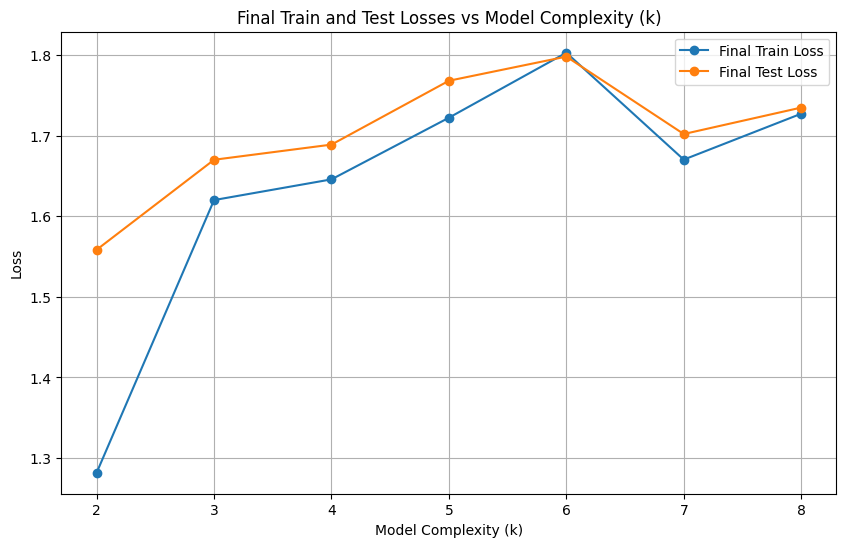

In [6]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Reduce training set size to simulate limited data scenario
small_train_size = 5000  # Use only 5000 samples
X_train, y_train = X_train[:small_train_size], y_train[:small_train_size]

# Preprocess the data
X_train, X_test = X_train / 255.0, X_test / 255.0  # Normalize to [0, 1]
y_train, y_test = to_categorical(y_train), to_categorical(y_test)  # One-hot encoding

# Function to build a smaller CNN model
def build_small_cnn_model(input_shape, num_classes, k):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    # Add convolutional layers with dynamic filters based on k
    model.add(layers.Conv2D(4, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(8 , (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Add a smaller fully connected layer
    model.add(layers.Flatten())
    model.add(layers.Dense(4 + k, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Parameters
input_shape = X_train.shape[1:]  # (32, 32, 3)
num_classes = 10
k_values = [2,3, 4, 5, 6, 7, 8]  # Different complexities to test

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

results = {}

# Loop over different values of k (model complexity)
for k in k_values:
    print(f"\nTraining with model complexity k={k}...")

    # Build and compile the model
    model = build_small_cnn_model(input_shape, num_classes, k)
    optimizer = Adam(learning_rate=0.005*1/(k+1))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()

    train_loss_list = []
    test_loss_list = []


    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,  # Train one epoch at a time to record intermediate results
        batch_size=24,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    # Stop early if early stopping criteria are met
    if len(history.history['val_loss']) > 1 and early_stopping.stopped_epoch:
        print("Early stopping triggered.")

    # Record the training and testing loss
    train_loss_list.append(history.history['loss'][-1])
    test_loss_list.append(history.history['val_loss'][-1])

    # Save final train and test losses for this complexity level
    results[k] = {
        "final_train_loss": train_loss_list[-1],
        "final_test_loss": test_loss_list[-1]
    }

    
# Visualization of final losses for different k values
k_values = list(results.keys())
train_losses = [results[k]["final_train_loss"] for k in k_values]
test_losses = [results[k]["final_test_loss"] for k in k_values]

plt.figure(figsize=(10, 6))
plt.plot(k_values, train_losses, label='Final Train Loss', marker='o')
plt.plot(k_values, test_losses, label='Final Test Loss', marker='o')
plt.xlabel('Model Complexity (k)')
plt.ylabel('Loss')
plt.title('Final Train and Test Losses vs Model Complexity (k)')
plt.legend()
plt.grid(True)
plt.show()

### Dense and RFF on MNIST

Here we run our experiences several times and plot the average loss over the simulations for Dense and RFF models on the MNIST data.

Processing calculations...


Models RFF-Adam-CE: 100%|██████████| 64/64 [02:02<00:00,  1.92s/it]


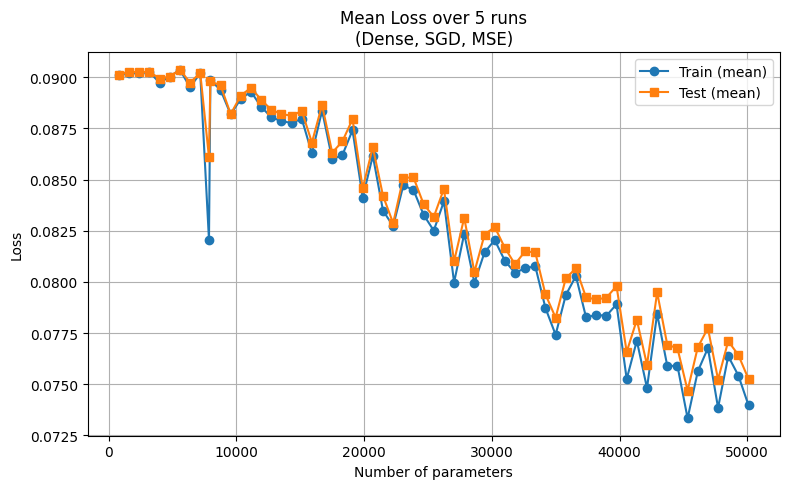

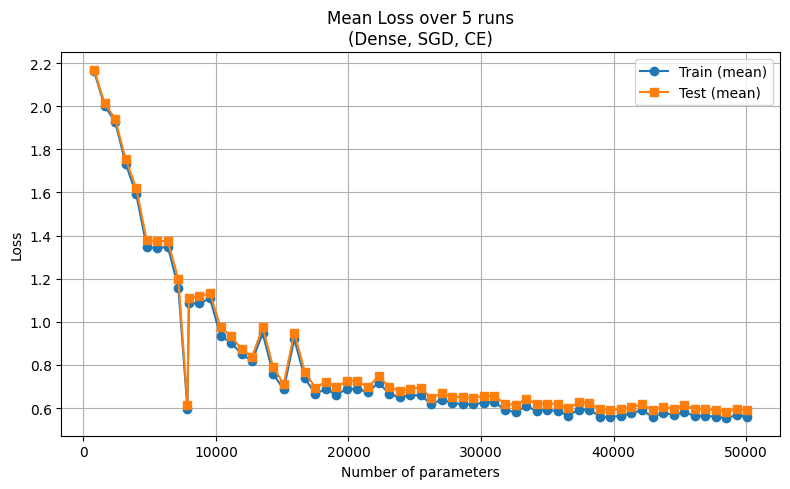

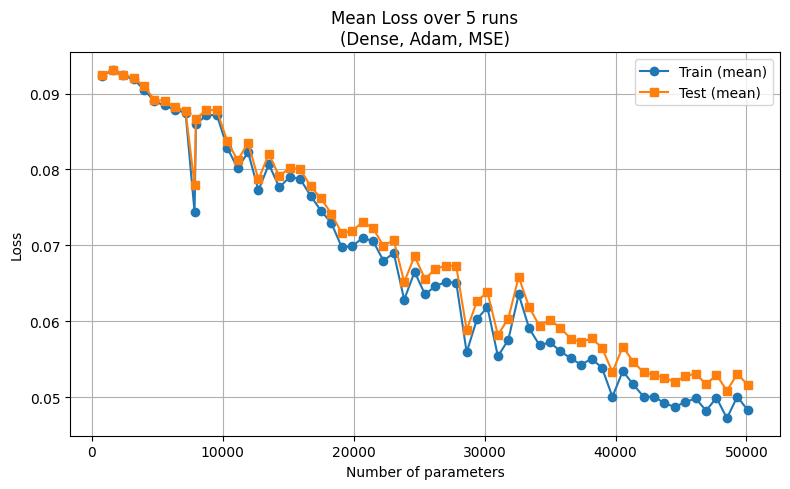

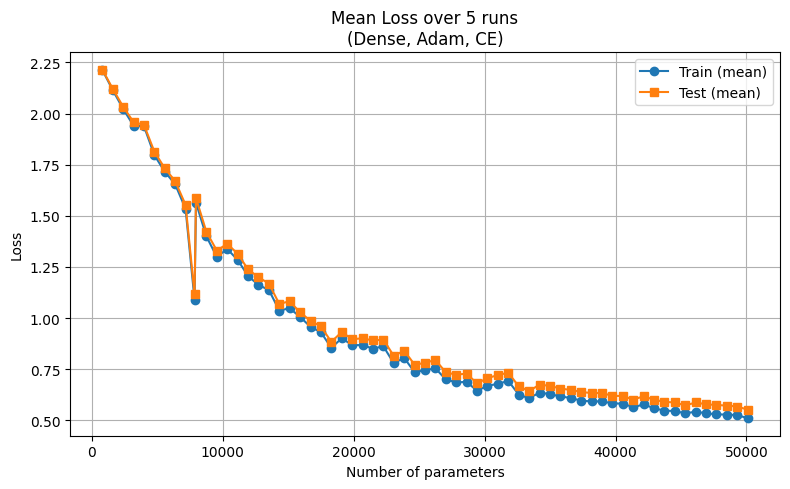

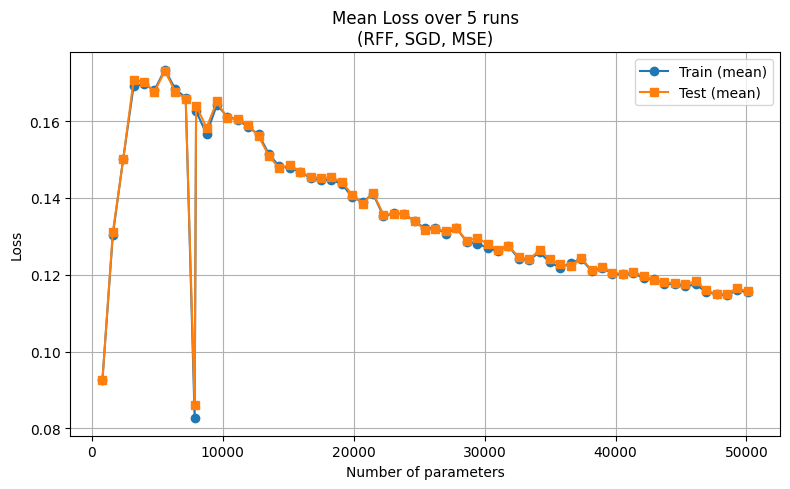

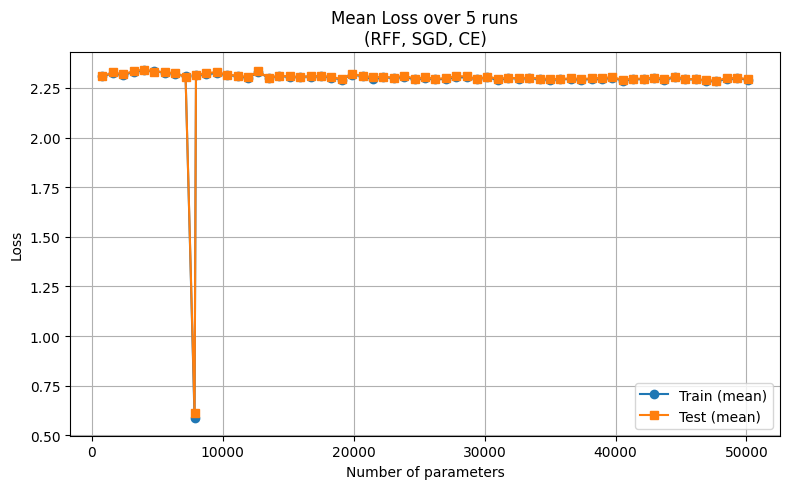

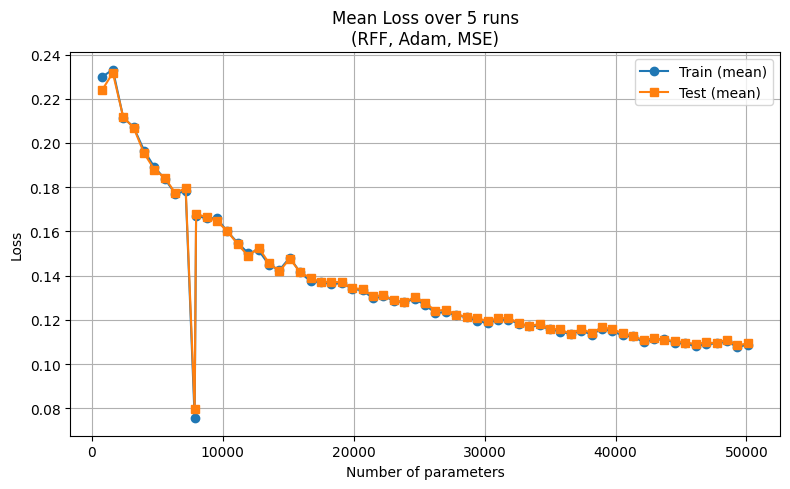

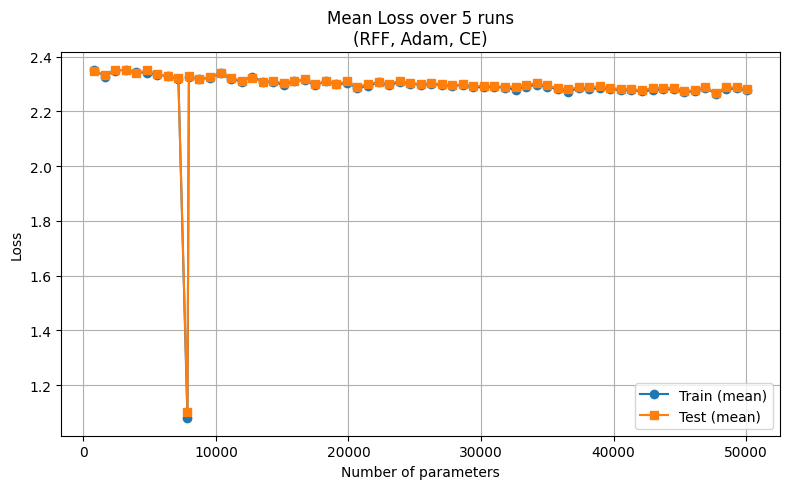

Experiment finished. Check df_agg for averaged statistics.


In [8]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all Python warnings

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Ignore TensorFlow info/warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, mean_squared_error

# ------------------------------------------------
# 1. Load and Preprocess MNIST Data
# ------------------------------------------------

(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

train_images = train_images[:4000]
train_labels = train_labels[:4000]

# Normalization
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Flatten
train_images_flat = train_images.reshape((-1, 28 * 28))
test_images_flat = test_images.reshape((-1, 28 * 28))

# ------------------------------------------------
# 2. Define a Custom Random Fourier Features Layer
# ------------------------------------------------

class RandomFourierFeatures(layers.Layer):
    """
    Custom Keras layer that computes Random Fourier Features (RFF):
      z(x) = sqrt(2/n_components) * cos(xW + b),
    where:
      - W ~ N(0, 2*gamma*I)
      - b ~ Uniform(0, 2pi)
    Weights are non-trainable.
    """
    def __init__(self, n_components=100, gamma=0.05, random_state=42, **kwargs):
        super(RandomFourierFeatures, self).__init__(**kwargs)
        self.n_components = n_components
        self.gamma = gamma
        self.random_state = random_state

    def build(self, input_shape):
        d = input_shape[-1]
        np.random.seed(self.random_state)
        W_init = np.random.normal(loc=0.0, scale=np.sqrt(2 * self.gamma),
                                  size=(d, self.n_components))
        b_init = np.random.uniform(low=0.0, high=2 * np.pi,
                                   size=(self.n_components,))
        
        self.W = self.add_weight(
            name="W",
            shape=W_init.shape,
            initializer=tf.constant_initializer(W_init),
            trainable=False
        )
        self.b = self.add_weight(
            name="b",
            shape=b_init.shape,
            initializer=tf.constant_initializer(b_init),
            trainable=False
        )
        super(RandomFourierFeatures, self).build(input_shape)

    def call(self, inputs):
        projection = tf.matmul(inputs, self.W) + self.b
        Z = tf.math.cos(projection) * tf.sqrt(2.0 / tf.cast(self.n_components, tf.float32))
        return Z

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_components)

# ------------------------------------------------
# 3. Model Building Functions
# ------------------------------------------------

def create_dense_model(n_hidden_units, activation='relu'):
    if n_hidden_units == 0:
        model = keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(10, activation='linear')
        ])
        return model
    
    model = keras.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(n_hidden_units, activation=activation),
        layers.Dense(10, activation='linear')
    ])
    return model

def create_rff_model(n_components, gamma=0.05, random_state=42):
    if n_components == 0:
        model = keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(10, activation='linear')
        ])
        return model
    
    inputs = layers.Input(shape=(784,))
    rff_features = RandomFourierFeatures(n_components=n_components,
                                         gamma=gamma,
                                         random_state=random_state)(inputs)
    outputs = layers.Dense(10, activation='linear')(rff_features)
    model = keras.Model(inputs, outputs)
    return model


# ------------------------------------------------
# 4. General Configuration
# ------------------------------------------------

# lr_features_list = [int(x) for x in np.linspace(10, 784, 64)]
# Dense/RFF: variation from 0 to 63
n_values_list = [int(x) for x in np.linspace(0, 63, 64)]

model_types = ['Dense', 'RFF']

optimizers_dict = {
    'SGD': {
        'class': optimizers.SGD,
        'params': {'learning_rate': 0.01, 'momentum': 0.95}
    },
    'Adam': {
        'class': optimizers.Adam,
        'params': {'learning_rate': 0.001}
    }
}

loss_functions_dict = {
    'MSE': losses.MeanSquaredError(),
    'CE': losses.SparseCategoricalCrossentropy(from_logits=True)
}

max_epochs = 3       
NUM_RUNS = 5         
BATCH_SIZE = 256    

# ------------------------------------------------
# 5. Collect All Results (Multiple Runs)
# ------------------------------------------------

all_results = []

print("Processing calculations...")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, mean_squared_error

for model_type in model_types:
    for optimizer_name, optimizer_info in optimizers_dict.items():
        optimizer_class = optimizer_info['class']
        optimizer_params = optimizer_info['params']
        for loss_name, loss_fn in loss_functions_dict.items():
            
            if model_type == 'LR':
                iterate_values = lr_features_list
            else:
                iterate_values = n_values_list
            
            for n_val in tqdm(iterate_values, desc=f"Models {model_type}-{optimizer_name}-{loss_name}"):
                for run_idx in range(NUM_RUNS):
                    
                    if model_type == 'LR':
                        X_train = train_images_flat[:, :n_val]
                        X_test = test_images_flat[:, :n_val]
                        clf = LogisticRegression(
                            multi_class='multinomial',
                            solver='lbfgs',
                            max_iter=500,      
                            random_state=run_idx,
                            n_jobs=-1          
                        )
                        clf.fit(X_train, train_labels)

                        probs_train = clf.predict_proba(X_train)
                        probs_test = clf.predict_proba(X_test)

                        if loss_name == 'CE':
                            train_loss = log_loss(train_labels, probs_train)
                            test_loss = log_loss(test_labels, probs_test)
                        else:
                            # MSE -> one-hot
                            n_classes = probs_train.shape[1]
                            onehot_train = np.eye(n_classes)[train_labels]
                            onehot_test = np.eye(n_classes)[test_labels]
                            train_loss = mean_squared_error(onehot_train, probs_train)
                            test_loss = mean_squared_error(onehot_test, probs_test)

                        n_params = n_val * 10 + 10
                    
                    else:
                        # Keras
                        model = None
                        if model_type == 'Dense':
                            model = create_dense_model(n_val, activation='relu')
                        else:
                            model = create_rff_model(n_val, gamma=0.05, random_state=42)
                        
                        optimizer = optimizer_class(**optimizer_params)
                        model.compile(optimizer=optimizer, loss=loss_fn)
                                                
                        model.fit(
                            train_images_flat,
                            tf.one_hot(train_labels, 10) if loss_name == 'MSE' else train_labels,
                            epochs=max_epochs,
                            batch_size=BATCH_SIZE,
                            verbose=0
                        )
                        
                        if loss_name == 'MSE':
                            train_loss = model.evaluate(
                                train_images_flat,
                                tf.one_hot(train_labels, 10),
                                verbose=0
                            )
                            test_loss = model.evaluate(
                                test_images_flat,
                                tf.one_hot(test_labels, 10),
                                verbose=0
                            )
                        else:
                            train_loss = model.evaluate(train_images_flat, train_labels, verbose=0)
                            test_loss = model.evaluate(test_images_flat, test_labels, verbose=0)
                        
                        n_params = model.count_params()
                    
                    all_results.append({
                        'model': model_type,
                        'optimizer': optimizer_name,
                        'loss_function': loss_name,
                        'n_features_or_units': n_val,
                        'n_parameters': n_params,
                        'train_loss': train_loss,
                        'test_loss': test_loss
                    })

# ------------------------------------------------
# 6. DataFrame and Aggregation
# ------------------------------------------------

df_all = pd.DataFrame(all_results)

df_agg = df_all.groupby(
    ['model', 'optimizer', 'loss_function', 'n_features_or_units', 'n_parameters'],
    as_index=False
).agg({
    'train_loss': 'mean',
    'test_loss': 'mean'
}).rename(columns={
    'train_loss': 'train_loss_mean',
    'test_loss': 'test_loss_mean'
})

# ------------------------------------------------
# 7. Visualization: Plot the Loss
# ------------------------------------------------

import matplotlib.pyplot as plt

def plot_mean_loss(df, model_type, optimizer, loss_function):
    subset = df[
        (df['model'] == model_type) &
        (df['optimizer'] == optimizer) &
        (df['loss_function'] == loss_function)
    ].copy()
    
    subset.sort_values(by='n_parameters', inplace=True)
    
    plt.figure(figsize=(8, 5))
    plt.plot(subset['n_parameters'], subset['train_loss_mean'],
             marker='o', label='Train (mean)')
    plt.plot(subset['n_parameters'], subset['test_loss_mean'],
             marker='s', label='Test (mean)')
    plt.xlabel('Number of parameters')
    plt.ylabel('Loss')
    plt.title(f'Mean Loss over {NUM_RUNS} runs\n({model_type}, {optimizer}, {loss_function})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# 8. Plot the Results
# ------------------------------------------------

for mtype in model_types:
    for opt_name in optimizers_dict.keys():
        for loss_name in loss_functions_dict.keys():
            plot_mean_loss(df_agg, mtype, opt_name, loss_name)

print("Experiment finished. Check df_agg for averaged statistics.")

## III - Experiences on artificial data

Here, we used synthetic data to exhibit the phenomenon, especially for the linear regressor model.

### Linear Regression

Here,  We generate 100 data points x from a uniform law on $[-2\pi, 2\pi]$ and then the target y was:

$y = 2cos(2x) + 3exp(\frac{x}{3}) + \epsilon$ 

where $\epsilon \sim N(0,0.3)$.

Degree 1 - Train MSE: 8.7913, Test MSE: 9.7155
Degree 2 - Train MSE: 2.9218, Test MSE: 3.1513


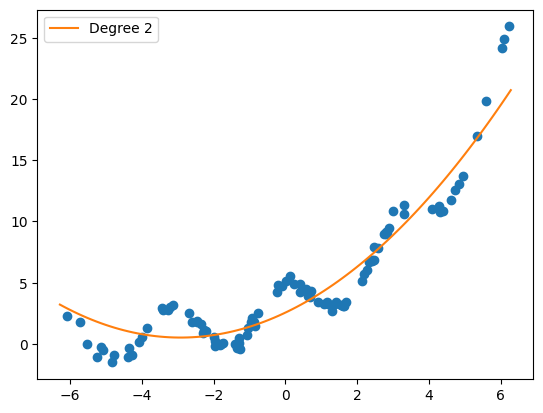

Degree 3 - Train MSE: 2.4097, Test MSE: 1.9376
Degree 4 - Train MSE: 2.2780, Test MSE: 1.5738


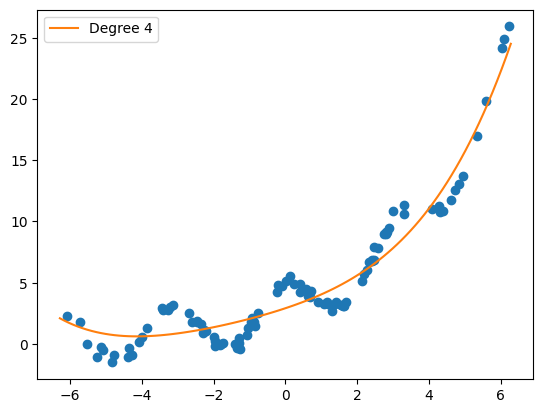

Degree 5 - Train MSE: 2.1214, Test MSE: 1.8744
Degree 6 - Train MSE: 1.8105, Test MSE: 1.3340


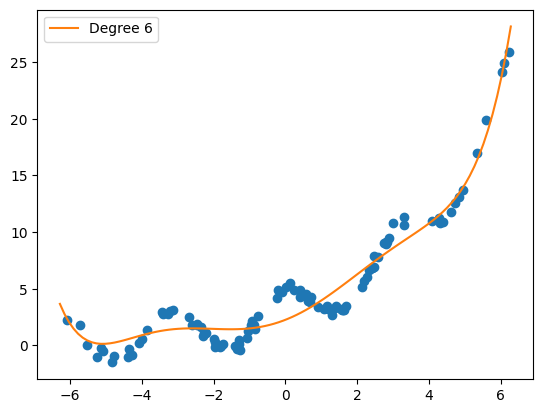

Degree 7 - Train MSE: 1.8105, Test MSE: 1.3352
Degree 8 - Train MSE: 1.6115, Test MSE: 1.7690


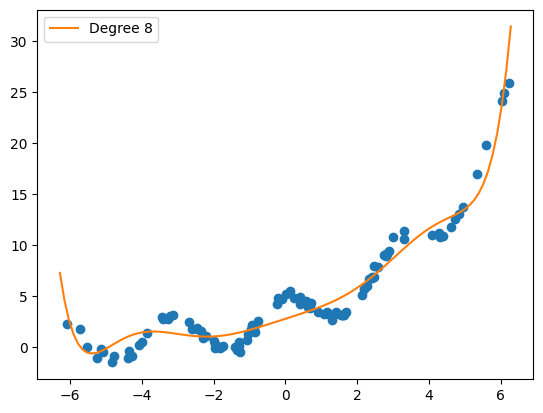

Degree 9 - Train MSE: 1.6103, Test MSE: 1.8463
Degree 10 - Train MSE: 0.4594, Test MSE: 2.0194


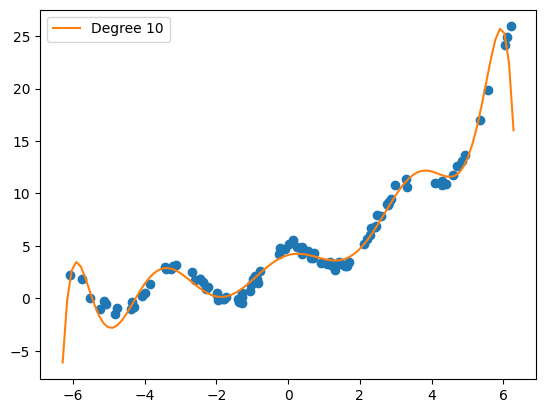

Degree 11 - Train MSE: 0.4497, Test MSE: 2.6847
Degree 12 - Train MSE: 0.1100, Test MSE: 0.7110


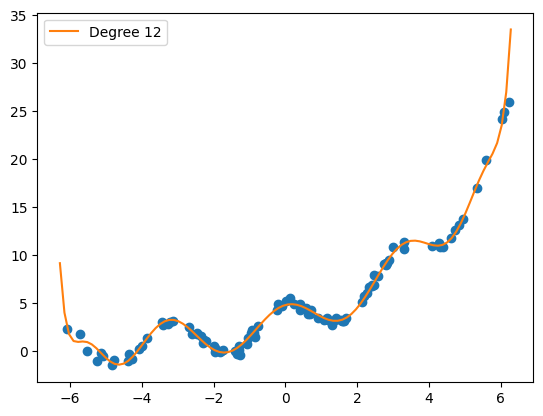

Degree 13 - Train MSE: 0.1068, Test MSE: 1.1459
Degree 14 - Train MSE: 0.0681, Test MSE: 0.1372


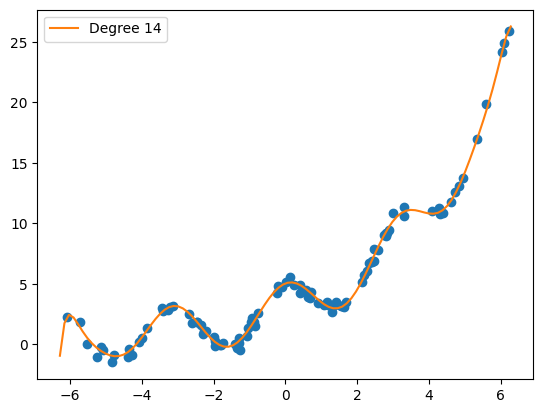

Degree 15 - Train MSE: 0.0656, Test MSE: 0.1942
Degree 16 - Train MSE: 0.0642, Test MSE: 0.1609


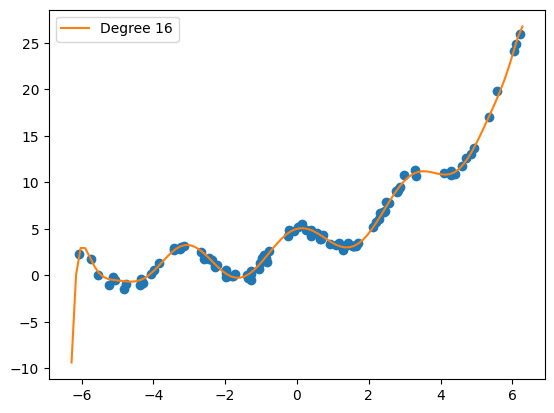

Degree 17 - Train MSE: 0.0642, Test MSE: 0.1608


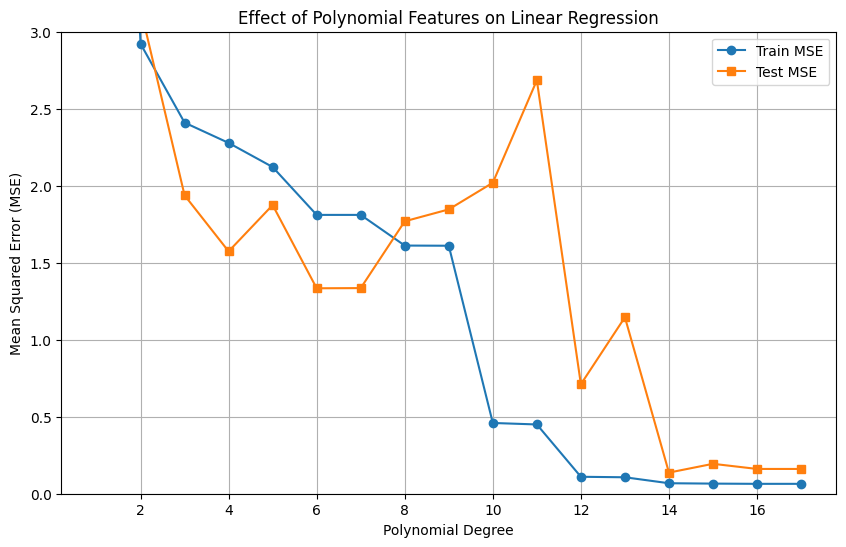

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. Generate synthetic dataset
np.random.seed(123)
n_samples = 100
X = np.random.uniform(-2*np.pi, 2*np.pi, size=(n_samples, 1)).flatten().reshape(-1, 1)  # X1, X2, X3 uniform between 0 and 2pi
y = 2*np.cos(2*X) + 3*np.exp(X/3) + np.random.normal(0, 0.3, n_samples).flatten().reshape(-1, 1)  # y = cos(X1 + X2 + X3) + noise

# 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# 3. Add polynomial features and track MSE
degrees = range(1, 18)  # Add polynomials up to degree 17
train_mse = []
test_mse = []

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=True)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Linear regression with augmented features
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predictions and MSE calculation
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))
    print(f"Degree {d} - Train MSE: {train_mse[-1]:.4f}, Test MSE: {test_mse[-1]:.4f}")
    if d % 2 == 0:
        x_plot = np.linspace(-2*np.pi, 2*np.pi, 100).reshape(-1, 1)
        plt.plot(X, y, 'o')
        plt.plot(x_plot, model.predict(poly.transform(x_plot)), label=f'Degree {d}')
        plt.legend()
        plt.show()

# 4. Visualize MSE (Train vs Test)
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_mse, label='Train MSE', marker='o')
plt.plot(degrees, test_mse, label='Test MSE', marker='s')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Effect of Polynomial Features on Linear Regression')
plt.legend()
plt.ylim(0, 3)
plt.grid(True)
plt.show()

We observe a double descent as long as we increase the degree (thus the number of parameters)

### RFF

An RFF model introduces a map z: $\mathbb{R}^d \to \mathbb{R}^N$ such that each input
$x \in \mathbb{R}^d$ is transformed via randomized cosine features. In the case of
approximating a Gaussian kernel, one typically sets:
$$
  z(x) \;=\;
  \sqrt{\tfrac{2}{N}}
  \begin{bmatrix}
    \cos(\omega_1^\top x + b_1)\\
    \vdots\\
    \cos(\omega_N^\top x + b_N)
  \end{bmatrix},
$$
where $\omega_i \sim \mathcal{N}(0, \sigma^2 I_d)$ and $b_i$ is sampled uniformly in
$[0,2\pi]$. A model in the RFF family is then
\[
  h_{\beta}(x) \;=\; \beta^\top z(x),
\]
where $\beta \in \mathbb{R}^N$ contains the \textbf{learnable} parameters. Observe that
$h_{\beta}(x)$ is \textbf{linear in} $\beta$ yet \textbf{non-linear in} $x$, which
is crucial: it links linear methods and kernel methods.

In [14]:
class RandomFourierFeatures:
    def __init__(self, input_dim, num_features, gamma=1.0):
        """
        Class to compute Random Fourier Features (RFF).

        Parameters:
        - input_dim : int, dimension of the input space.
        - num_features : int, number of features in the transformed space.
        - gamma : float, parameter of the RBF kernel (1 / (2 * sigma^2)).
        """
        self.input_dim = input_dim
        self.num_features = num_features
        self.gamma = gamma
        
        # Initialization of random vectors and biases
        self.W = np.sqrt(2 * gamma) * np.random.randn(input_dim, num_features)
        self.b = 2 * np.pi * np.random.rand(num_features)

    def transform(self, X):
        """
        Transforms input data X into the Random Fourier Features space.

        Parameters:
        - X : numpy.ndarray, input data of shape (n_samples, input_dim).

        Returns:
        - numpy.ndarray of shape (n_samples, num_features).
        """
        
        # Compute linear projection and add bias
        Z = X @ self.W + self.b
        
        # Apply cosine function and return the projection
        Z = np.asarray(Z, dtype=np.float64)
        return np.sqrt(2 / self.num_features) * np.cos(Z)


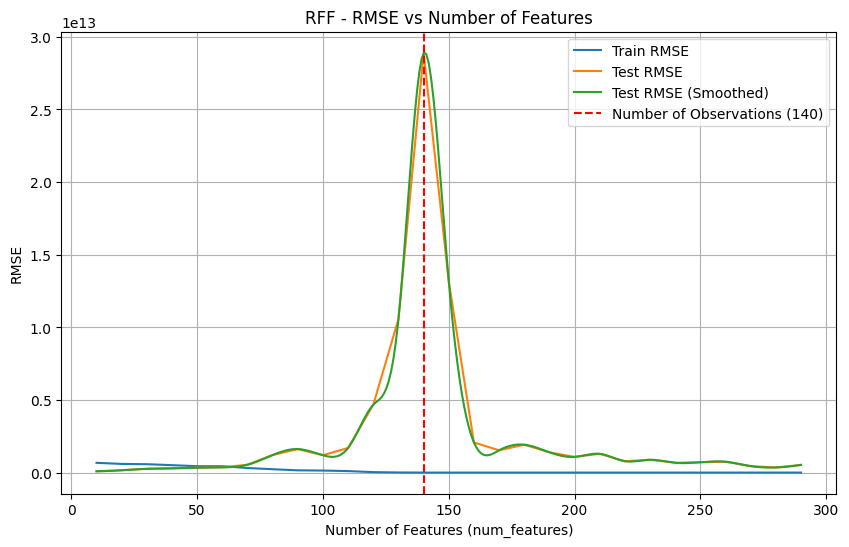

Number of observations: 140


In [16]:

# 1 Generate synthetic dataset
np.random.seed(123)
n_samples = 200

X = np.random.uniform(-np.pi*2, 2*np.pi, size=(n_samples, 3))  # X1, X2, X3 uniformes entre 0 et 2pi
y = np.exp(X[:, 0] + X[:, 1] + X[:, 2]) + np.random.normal(0, 0.3, n_samples)  # y = cos(X1 + X2 + X3) + bruit

# 2 Division en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


# Parameters
input_dim = 3      # Dimension of the input space
gamma = 0.5        # Parameter of the RBF kernel

# List of number of features to test
n_features_list = list(range(10, 300, 10))
train_rmse_list = []
test_rmse_list = []

# Loop to train and evaluate RFF with different numbers of features
for num_features in n_features_list:
    rff = RandomFourierFeatures(input_dim, num_features, gamma)
    
    # Transform data
    X_train_transformed = rff.transform(X_train)
    X_test_transformed = rff.transform(X_test)

    # Fit a simple linear model in the transformed space
    weights = np.linalg.pinv(X_train_transformed) @ y_train

    # Predictions
    y_pred_train = X_train_transformed @ weights
    y_pred_test = X_test_transformed @ weights

    # Calculate RMSE
    train_rmse = mean_squared_error(y_train, y_pred_train)
    test_rmse = mean_squared_error(y_test, y_pred_test)

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

# Visualization of results
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, train_rmse_list, label='Train RMSE')
plt.plot(n_features_list, test_rmse_list, label='Test RMSE')

# Spline interpolation for smoother curves
x_smooth = np.linspace(min(n_features_list), max(n_features_list), 300)
spline_test = make_interp_spline(n_features_list, test_rmse_list, k=3)

y_smooth_test = spline_test(x_smooth)

plt.plot(x_smooth, y_smooth_test, '-', label='Test RMSE (Smoothed)')
plt.xlabel('Number of Features (num_features)')
plt.ylabel('RMSE')
plt.title('RFF - RMSE vs Number of Features')
plt.axvline(x=X_train.shape[0], color='red', linestyle='--', label=f'Number of Observations ({X_train.shape[0]})')
plt.legend()
plt.grid(True)
plt.show()

print("Number of observations:", X_train.shape[0])

### Random forest

Here we tried to reproduce the double descent phenomenon with a random forest. The problem is that the model can become very quickly complex and yet robust. To counteract this effect, we implemented a random forest of shallow trees, where each tree has a depth of 1 and is trained on 10% of the data.
Based on the fact that the number of parameters of a tree is around $3n_{leaf}−2$, the number of parameters of a tree with max depth of 1 is therefore 4 (there are two leaves). So in such random forest, the number of parameters is the number of tree time 4. We should observe the double descent around n/4 accordingly.

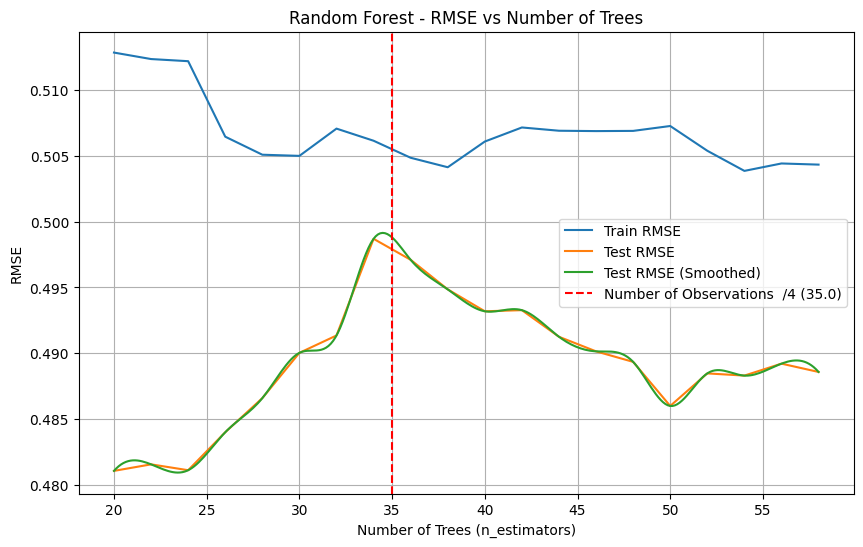

Number of observations: 140


In [65]:
from sklearn.ensemble import RandomForestRegressor

# Generate synthetic data
np.random.seed(123)
n_samples = 200
X = np.random.uniform(-np.pi*2, 2*np.pi, size=(n_samples, 3))  # X1, X2, X3 uniform between 0 and 2pi
y = np.cos(X[:, 0] + X[:, 1] + X[:, 2]) 

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# List of number of trees to test
n_trees_list = list(range(20, 60, 2))
train_rmse_list = []
test_rmse_list = []

# Loop to train and evaluate Random Forest with different numbers of trees
for n_trees in n_trees_list:
    rf = RandomForestRegressor(n_estimators=n_trees, max_depth=1,  max_samples=0.1, random_state=123)

    # Train the Random Forest
    rf.fit(X_train, y_train)

    # Predictions
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    # Calculate RMSE
    train_rmse = mean_squared_error(y_train, y_pred_train)
    test_rmse = mean_squared_error(y_test, y_pred_test)

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

# Visualization of results
plt.figure(figsize=(10, 6))
plt.plot(n_trees_list, train_rmse_list, label='Train RMSE')
plt.plot(n_trees_list, test_rmse_list, label='Test RMSE')

# Spline interpolation for smoother curves
x_smooth = np.linspace(min(n_trees_list), max(n_trees_list), 300)
spline_test = make_interp_spline(n_trees_list, test_rmse_list, k=3)

y_smooth_test = spline_test(x_smooth)

plt.plot(x_smooth, y_smooth_test, '-', label='Test RMSE (Smoothed)')

# Add vertical line for number of observations
plt.axvline(x=X_train.shape[0]/4, color='red', linestyle='--', label=f'Number of Observations  /4 ({X_train.shape[0]/4})')
#plt.axvline(x=X_train.shape[0]/2, color='red', linestyle='--', label=f'Number of Observations /2 ({X_train.shape[0]/2})')
#plt.axvline(x=X_train.shape[0], color='red', linestyle='--', label=f'Number of Observations  ({X_train.shape[0]})')

plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.title('Random Forest - RMSE vs Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

print("Number of observations:", X_train.shape[0])
